X_train shape: (700, 9)
X_test shape: (300, 9)


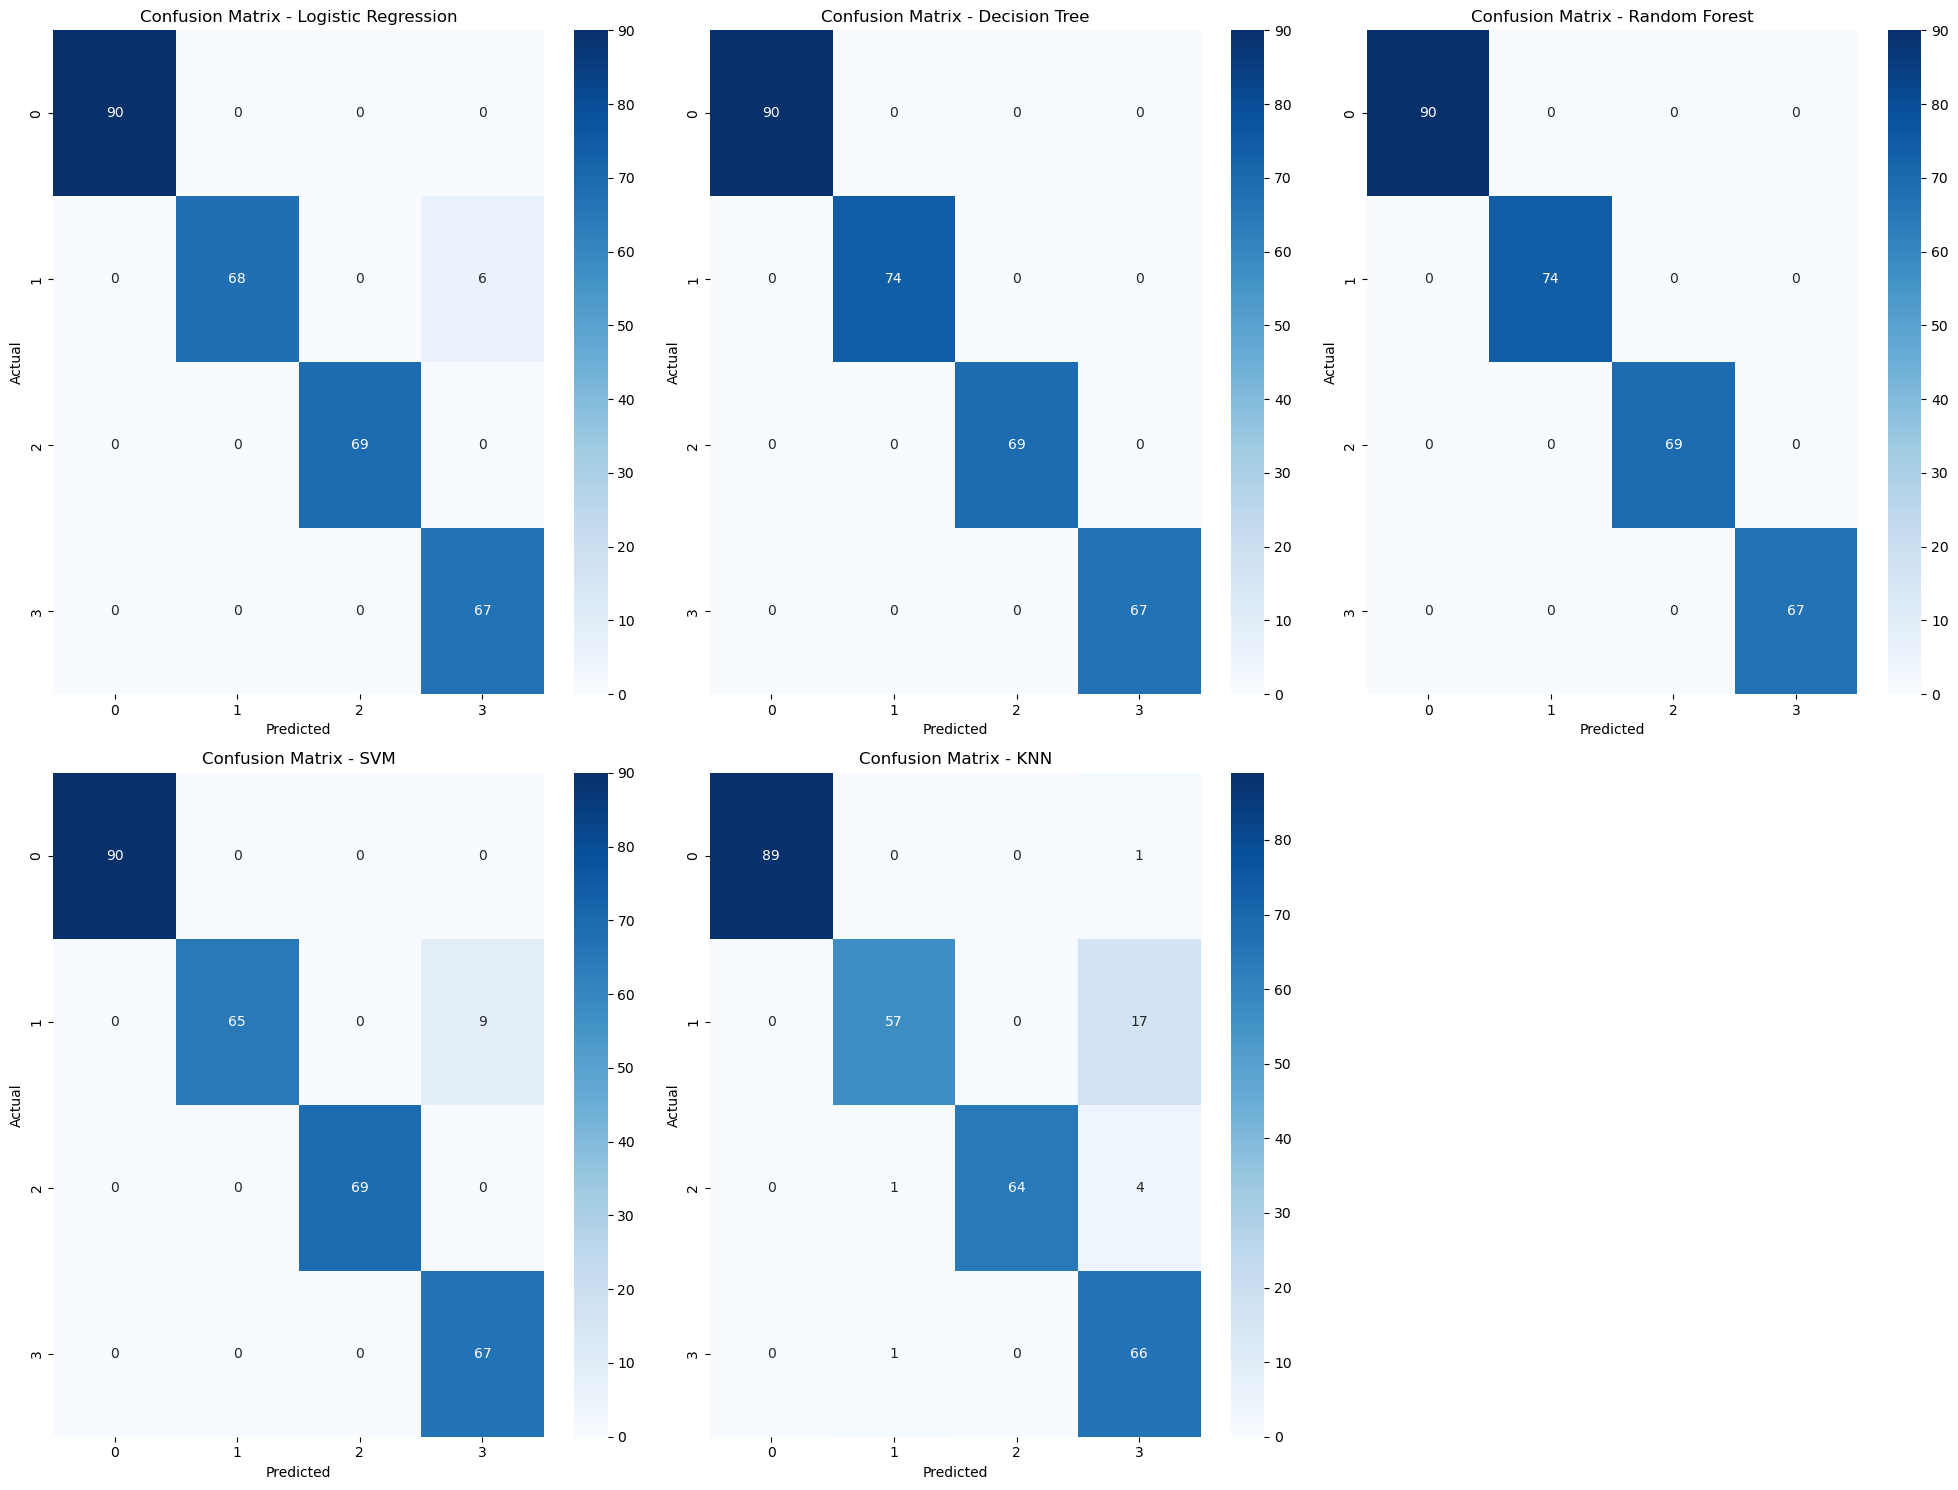

+---------------------+--------------------+--------------------+----------+--------+--------------------+
|      Algorithm      |      ROC AUC       |      F1 Score      | Accuracy | Recall |     Precision      |
+---------------------+--------------------+--------------------+----------+--------+--------------------+
| Logistic Regression |        1.0         | 0.9800060362173039 |   0.98   |  0.98  | 0.9816438356164383 |
|    Decision Tree    |        1.0         |        1.0         |   1.0    |  1.0   |        1.0         |
|    Random Forest    |        1.0         |        1.0         |   1.0    |  1.0   |        1.0         |
|         SVM         | 0.9999839856511434 | 0.9699728329224733 |   0.97   |  0.97  | 0.9735526315789474 |
|         KNN         | 0.9879473649593797 | 0.9212995256206835 |   0.92   |  0.92  | 0.9358050847457627 |
+---------------------+--------------------+--------------------+----------+--------+--------------------+


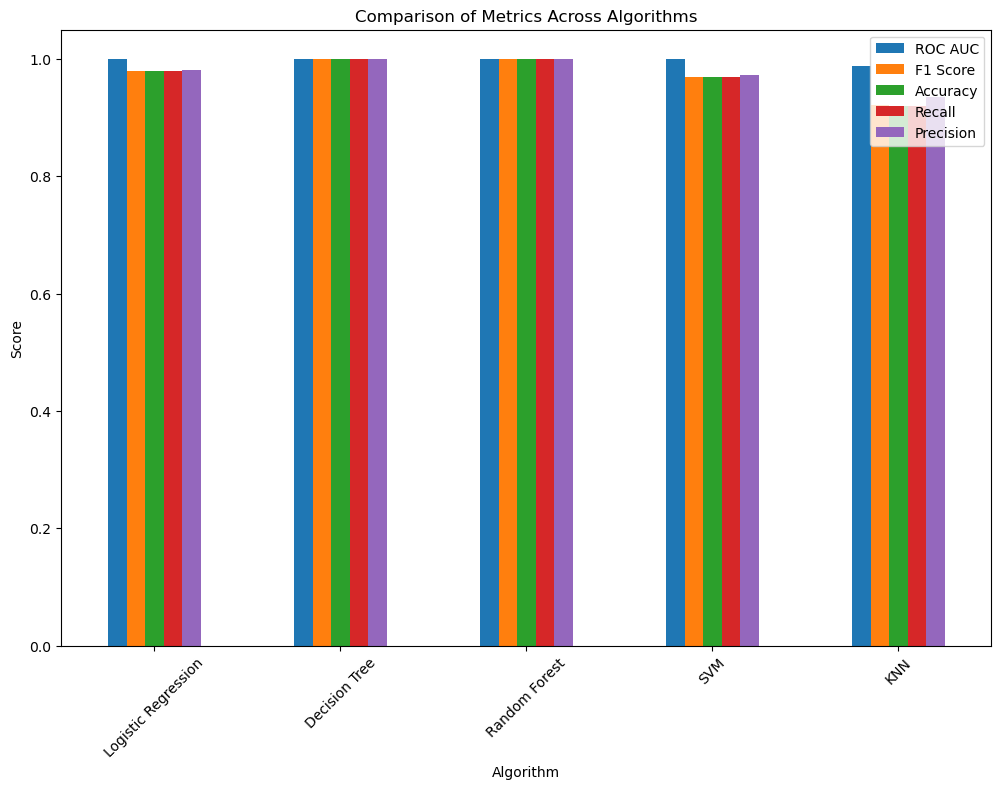

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Load the dataset
df = pd.read_csv('natural_disaster_dataset.csv')

# Encode categorical variables
label_encoder = LabelEncoder()
df['Disaster_Type'] = label_encoder.fit_transform(df['Disaster_Type'])

# Handle missing values if any
df.fillna(0, inplace=True)

# Features and target variable
if 'ID' in df.columns:
    X = df.drop(columns=['ID', 'Disaster_Type'])
else:
    X = df.drop(columns=['Disaster_Type'])
    
y = df['Disaster_Type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import numpy as np

# Ensure only numerical columns are present
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

# Handle missing values
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Remove constant features
selector = VarianceThreshold(threshold=0)
X_train = selector.fit_transform(X_train)
X_test = selector.transform(X_test)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Ensure shapes match
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier()
}

# Binarize the target variable for multi-class ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))

# Evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Handle models without predict_proba
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)
    else:
        y_pred_proba = np.zeros((len(y_test), len(np.unique(y))))  # Dummy probabilities

    # Compute multi-class ROC AUC
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(y_test_bin.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    avg_roc_auc = np.mean(list(roc_auc.values()))
    
    results[name] = {
        'ROC AUC': avg_roc_auc,
        'F1 Score': f1_score(y_test, y_pred, average='weighted'),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }

# Plot Confusion Matrices
plt.figure(figsize=(20, 15))
for i, (name, result) in enumerate(results.items(), 1):
    plt.subplot(2, 3, i)
    sns.heatmap(result['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Create a table of metrics
metrics_table = []
for name, result in results.items():
    metrics_table.append([
        name,
        result['ROC AUC'],
        result['F1 Score'],
        result['Accuracy'],
        result['Recall'],
        result['Precision']
    ])

# Print metrics table
print(tabulate(metrics_table, headers=['Algorithm', 'ROC AUC', 'F1 Score', 'Accuracy', 'Recall', 'Precision'], tablefmt='pretty'))

# Plot bar plot for metrics
metrics_df = pd.DataFrame(metrics_table, columns=['Algorithm', 'ROC AUC', 'F1 Score', 'Accuracy', 'Recall', 'Precision'])
metrics_df.set_index('Algorithm', inplace=True)

metrics_df.plot(kind='bar', figsize=(12, 8))
plt.title('Comparison of Metrics Across Algorithms')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()
